# Theory

## Crank Nicolson

The standalone Crank-Nicolson scheme is found to have a first order convergence due to the weakly damped high frequency error terms (as a result of the non-smooth initial condition). Thus, the Richardson extrapolations may be implemented as follows:

#### Low wavenumber error
- $O(h^{2})$
- next error order for CN is $O(h^i)$
- next order for Rannacher is $O(h^i)$


$$\hat{V}^{[1]} = \frac{4}{3}\hat{V_{h}} - \frac{1}{3}\hat{V_{2h}}$$


#### High wavenumber error
- $O(h^{1})$ where $R$ = 0
- next error order for CN is $O(h^i)$
- next order for Rannacher is $O(h^i)$


$$\hat{V}^{[1]} = 2\hat{V_{h}} - 1\hat{V_{2h}}$$

## Rannacher Timestepping

#### Low wavenumber error
- $O(h^{2})$
- next error order for CN is $O(h^i)$
- next order for Rannacher is $O(h^i)$

$$\hat{V} = \frac{4}{3}\hat{V_{h}} - \frac{1}{3}\hat{V_{2h}}$$

#### High wavenumber error
- $O(h^{2R+1})$ where $R$ = 2
- next error order for CN is $O(h^i)$
- next order for Rannacher is $O(h^i)$

$$\hat{V} = \frac{2^{2R+1}\hat{V_{h}} - \hat{V_{2h}}}{2^{2R+1}-1}$$

# Prerequisites

In [1]:
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
import math as m
import time 
from numpy.lib.format import open_memmap
import pandas as pd

### The Thomas Algorithm
The thomas algorithm is a more computationally efficient way to solve for the unknowns as compared to matrix inversion (works via LU decomposition).

In [2]:
# Define the tridiagonal matrix solver algorithm for BLACK-SCHOLES EQUATION FORMAT
'''
For Tx = d
Inputs:
    - a = lower triangular vector
    - b = diagonal vector
    - c = upper diagonal vector
    - d = -aV_{i-1}^n + (1 + b)V_i^n - cV_{i+1}^n = constant term of knowns for share prices (i-1, i, i+1) at time n
Output:
    - unew = updated v values over space for time n+1
'''
def TDMA(a,b,c,d):
    n = len(d)
    e = np.zeros(n-1)
    f = np.zeros(n)
    V = np.zeros(n)
    
    e[0] = c[0]/b[0]
    f[0] = d[0]/b[0]
    for i in range(1,n-1):
        e[i] = c[i]/(b[i] - a[i]*e[i-1])
    for i in range(1,n):
        f[i] = (d[i] - a[i]*f[i-1])/(b[i] - a[i]*e[i-1])
    
    V[n-1] = f[n-1]
    for i in range(n-1,0,-1):
        V[i-1] = f[i-1] - e[i-1]*V[i]
    return V

### Call Option  Parameters

In [3]:
### // CALL OPTION PARAMETERS /// ###
sig = 0.15 # volatility (std deviation of log returns)
K = 10 # dollars
T = 2 # years
r = 0.02 # yearly risk free interest rate

### Analytical Solution

In [4]:
# import packages
import matplotlib.pyplot as plt
import numpy as np
import math
#import sympy as sy

def erf(x):
    if isinstance(x, (int, float)):
        erf = m.erf(x)
    else:
        erf = np.array([m.erf(x) for x in x])
        
    return erf


# function for N(x) - normal CDF
def N(x) :
    return 0.5*(erf(x/np.sqrt(2)) + 1)


'''
# function to calculate the analytical solution to the black scholes equation for a european call given parameters
# INPUTS : 
    - Z = log stock price (vector)
    - t = time
    - sig = volatility 
    - K = strike price 
    - T = expiry time 
    - r = risk free rate 
    - N = Cumulative normal distribution function (defined above)
OUTPUTS : 
    - Analytical solution for European Call
'''

def BS_analytic_Z(Z, t, sig = sig, K = K, T = T, r = r, N = N) :
    # S=0 implies a zero value, S=0 implies the log going to negative infinity and the cumulative distributions having values 0.
    def d1(Z):
        return (Z - np.log(K) + (r + 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    def d2(Z):
        return (Z - np.log(K) + (r - 0.5*sig**2) * (T - t)) / (sig * (T - t)**(0.5))
    
    ECall = np.where(np.exp(Z) == 0, 0, np.exp(Z)*N(d1(Z)) - K*np.exp(-r*(T-t))*N(d2(Z)))
    
    return ECall

## CALCULATES ERROR AT GIVEN TIME STEP
def DErrors_Z(Num, Z):
    return Num - BS_analytic_Z(Z, t=0)

## CN Specific

### Present Value Function

In [5]:
def PresentValue(dt, dZ, Zmax, sig=sig, K=K, r=r, T=T): #ADD Zmax
    ### SETTING PARAMETERS
    Smin = 1e-10
    Smax = 500
    Zmin = np.log(Smin)
    
    nt = int(T/dt)
    iZ = m.floor((Zmax-Zmin) / dZ)
    Z = np.linspace(Zmin, Zmax, iZ + 1) 
    
    print('Present Value Function:')
    print(f'dz = {dZ}')
    print(f'dt = {dt}')
    print(f'lamda = {dt/dZ}')
    print(f'new Smax = {np.exp(Zmax)}')
    print(f'nt = {nt}')
     #----------------------------------------------------------------------------------------
    
    ### INITIAL AND BOUNDARY CONDITIONS
    VIC = np.maximum(np.exp(Z) - K, 0)

    VB1 = 0
    VB2 = Smax

    VIC[0] = VB1 # still use zero as the boundary value
    VIC[-1] = VB2
    
     #----------------------------------------------------------------------------------------
    
    ### SOLVING THE TRIDIAGONAL SYSTEM
    # Define solution matrix
    V = np.memmap('CNPVmatrix.arr', dtype=np.float64, mode='w+', shape=(iZ-1, nt+1))
    
    # add initial conditions in first column
    V[:,0] = VIC[1:-1]
    
    # Define tridiagonal system
    # constants in system
    ac = (dt/4 * (sig**2/dZ**2 - (r - 0.5*sig**2)/dZ))
    bc = (dt/2 * (sig**2/dZ**2 + r)) # care with 1 +/- b
    cc = (dt/4 * (sig**2/dZ**2 + (r - 0.5*sig**2)/dZ))

    # vectors of tridiagonal
    a = - ac * np.ones(iZ-1) # lower diag
    b = (1 + bc) * np.ones(iZ-1) # diag has (1 - bc)
    c = - cc * np.ones(iZ-1) # upper diag


    # empty RHS vector
    d = np.zeros(iZ-1)


    # iterate over time, note here the middle value has (1 + bc)
    for j in range(1, nt+1):
        # left boundary
        d[0] = (ac*VB1 + (1 - bc)*V[0,j-1] + cc*V[1,j-1]) + ac*VB1
        # no boundaries involved
        d[1:-1] = (ac*V[0:-2,j-1] + (1 - bc)*V[1:-1,j-1] + cc*V[2:,j-1])
        # right boundary
        d[-1] = (ac*V[-2,j-1] + (1 - bc)*V[-1,j-1] + cc*VB2) + cc*VB2 #problematic
    
        # store solution
        V[:,j] = TDMA(a,b,c,d)
        
    V.flush()
    
    V = np.memmap('CNPVmatrix.arr', dtype=np.float64, mode='r', shape=(iZ-1, nt+1)) 

    # Matrix of results
    # Add the i=0 and i=nS boundary condition values
    
    Vsol = np.zeros((iZ+1, nt+1))
    V0 = np.array([VB1])
    ViZ = np.array([VB2])
    
    for j in range(nt+1):
        Vsol[:,j] = np.concatenate((V0, V[:,j], ViZ), axis=0)

    return Vsol[:,-1]

## Rannacher Specific

### Rannacher Timestepping Function
Currently calculates the first two integer time steps using half-steps of Backwards Euler. Can potentially implement customizable numbers of points to replace, and the factor of stepping in the intermediate steps. 

In [6]:
def RannacherStart(Vinit, R, dt, dZ, iZ, VIC):
    # define half time step
    hdt = dt/2
    
    Smin = 1e-10 # can no longer use Smin = 0 as log(0) = -inf, use a small number as replacement
    Smax = 500 # can use even larger Smax as ln transformation squishes results quicker
    Zmin = np.log(Smin) # low boundary
    Zmax = np.log(Smax) # high bonudary
    VB1 = 0
    VB2 = Smax
    
    # Store all 
    Vinit_halfs = np.zeros((iZ-1, 2*R+1))
    Vinit_halfs[:,0] = VIC[1:-1]
    
    # constants in tridiagonal system
    ac = (hdt/2 * (sig**2/dZ**2 - (r - 0.5*sig**2)/dZ))
    bc = (hdt * (sig**2/dZ**2 + r)) # care with 1 +/- b
    cc = (hdt/2 * (sig**2/dZ**2 + (r - 0.5*sig**2)/dZ))

    # vectors of tridiagonal
    a = - ac * np.ones(iZ-1) # lower diag
    b = (1 + bc) * np.ones(iZ-1) # diag has (1 - bc)
    c = - cc * np.ones(iZ-1) # upper diag
    
    # initialise constant vector
    d = np.zeros(iZ-1)
    
    # Solve the tridiagonal system for one half-step using Vinit
    for n in range(1, 2*R+1):
        # Half step
        # i=1: Includes i=0 boundary
        d[0] = Vinit_halfs[0, n-1] + ac*VB1
        
        # i=2,...,iZ-2: no boundary values
        d[1:-1] = Vinit_halfs[1:-1, n-1]
        
        # i=iZ-1: Includes i=iZ boundary
        d[-1] = Vinit_halfs[-1, n-1] + cc*VB2
        
        # Calculate half-step results
        Vinit_halfs[:,n] = TDMA(a, b, c, d)
        
    # Get the two whole steps
    for s in range(1, R+1):
        Vinit[:, s] = Vinit_halfs[:, 2*s]
    
    return Vinit

### Rannacher Present Value of European Call (2R 1/2 steps)

In [7]:
def PV_Rannacher(dt, dZ, R=2, sig=sig, K=K, r=r, T=T):
    ### SETTING PARAMETERS
    Smin = 1e-10 # can no longer use Smin = 0 as log(0) = -inf, use a small number as replacement
    Smax = 500 # can use even larger Smax as ln transformation squishes results quicker
    Zmin = np.log(Smin) # low boundary
    Zmax = np.log(Smax) # high bonudary
    iZ = round((Zmax-Zmin) / dZ)
    
    dZ = (Zmax-Zmin)/iZ # update to fit grid boundaries

    Z = np.linspace(Zmin, Zmax, iZ + 1) # Nx total grid points from 0 to L included (combine two np.linspace of different step sizes)
    nt = int(round(T/dt)) # number of steps in time
    dt = T/nt
    
    print(f'Stepsizes: dz = {dZ} and dt = {dt}')
    print(f'lambda = {dt/dZ}')

     #----------------------------------------------------------------------------------------
    
    ### INITIAL AND BOUNDARY CONDITIONS
    VIC = np.maximum(np.exp(Z) - K, 0)

    VB1 = 0
    VB2 = Smax

    VIC[0] = VB1 # still use zero as the boundary value
    VIC[-1] = VB2
    
     #----------------------------------------------------------------------------------------
    
    ### SOLVING THE TRIDIAGONAL SYSTEM ---> first two CN steps replaced with 2nd and 4th Laasonen half-steps
    # Define solution matrix
    V = np.memmap('RCNPVmatrix.arr', dtype=np.float64, mode='w+', shape=(iZ-1, nt+1)) # np.zeros((iZ-1, nt+1))
    # Initialise starting matrix
    Vstart = np.zeros((iZ-1, nt+1))
    # add initial conditions in first column
    Vstart[:,0] = VIC[1:-1]

    ## Rannacher timestepping
    VRanStart = RannacherStart(Vinit=Vstart.copy(), R=R, dt=dt, dZ=dZ, iZ=iZ, VIC=VIC).copy()
    for j in range(nt+1):
        V[:, j] = VRanStart[:,j]
    
    ## Crank-Nicolson
    # Define tridiagonal system
    # constants in system
    ac = (dt/4 * (sig**2/dZ**2 - (r - 0.5*sig**2)/dZ))
    bc = (dt/2 * (sig**2/dZ**2 + r)) # care with 1 +/- b
    cc = (dt/4 * (sig**2/dZ**2 + (r - 0.5*sig**2)/dZ))

    # vectors of tridiagonal
    a = - ac * np.ones(iZ-1) # lower diag
    b = (1 + bc) * np.ones(iZ-1) # diag has (1 - bc)
    c = - cc * np.ones(iZ-1) # upper diag

    # check diagonal dominance for thomas algorithm stability
    print('\n Tridiagonal system coefficients:')
    print(f'lower diag values = {-ac}')
    print(f'diag values = {1 + bc}')
    print(f'upper diag values = {-cc}')


    # empty RHS vector
    d = np.zeros(iZ-1)


    # iterate over time, excluding first two timesteps solved with Rannacher timestepping
    for j in range(R+1, nt+1):
        # left boundary
        d[0] = (ac*VB1 + (1 - bc)*V[0,j-1] + cc*V[1,j-1]) + ac*VB1
        # no boundaries involved
        d[1:-1] = (ac*V[0:-2,j-1] + (1 - bc)*V[1:-1,j-1] + cc*V[2:,j-1])
        # right boundary
        d[-1] = (ac*V[-2,j-1] + (1 - bc)*V[-1,j-1] + cc*VB2) + cc*VB2 #problematic
    
        # store solution
        V[:,j] = TDMA(a,b,c,d)
    
    V.flush()
    
    V = np.memmap('RCNPVmatrix.arr', dtype=np.float64, mode='r', shape=(iZ-1, nt+1)) 

    # Matrix of results
    # Add the i=0 and i=nS boundary condition values

    Vsol = np.zeros((iZ+1,nt+1))
    V0 = np.array([VB1])
    ViZ = np.array([VB2])
    
    for j in range(nt+1):
        Vsol[:,j] = np.concatenate((V0, V[:,j], ViZ), axis=0)
    
    return Vsol[:,-1] 

# 1. Crank-Nicolson Richardson Extrapolation

## Cancelling SECOND Order Leading Error (LOW FREQUENCY)

### Function

In [8]:
'''
Define the 2h step first, and make sure it fits
'''
def CNRE_2OE(dt, lda, sig=sig, K=K, r=r, T=T):
    # Parameters
    Smin = 1e-10
    Smax = 500
    Zmin = np.log(Smin)
    Zmax = np.log(Smax)
    
    nt = int(T/dt)
    dZ = dt/lda
    iZ = m.floor((Zmax-Zmin) / dZ)
    Zmax = Zmin + dZ*iZ
    
    # iZ = round((Zmax-Zmin)/dZ)
    # dZ = (Zmax-Zmin) / iZ
    # nt = round(T/dt)
    # dt = T/nt
    
    print(f'2h = {dZ}')
    print(f'2k = {dt}')
    print(f'lamda = {dt/dZ}')
    print(f'nt = {nt}')
    print(f'iZ = {iZ}')
    print(f'new Smax = {np.exp(Zmax)}')
    
    
    Z_2h = np.linspace(Zmin, Zmax, iZ+1)
    
    # Calculate CN Result for step size 2*dZ 
    V_2h = PresentValue(dZ = dZ, dt = dt, Zmax=Zmax)
    
    # Calculate CN Result for step size dZ
    V_h = PresentValue(dZ = dZ/2, dt = dt/2, Zmax=Zmax)
    
    
    # Conduct Richardson Extrapolation of Results: Solutions are only obtainable at the 2h steps (as no values calculated between 2h steps, as for h step case)
    V = np.zeros(iZ+1)
    for i in range(iZ+1):
        V[i] = 4/3 * V_h[2*i] - 1/3 * V_2h[i] 

    
    ### ---------------------------------------------
    # Calculate Max Error in Realistic Region

    # Errors
    # max
    Errors = DErrors_Z(V, Z_2h)
    # abs max
    Aerror = np.abs(Errors)
    
    
    # Define a cutoff at a large enough S and corresponding Z - THE REALISTIC DOMAIN
    Scut = 100
    Zcut = np.log(Scut)
    cutoff = int((Zcut - Zmin) / dZ)

    R_AE = Aerror[:cutoff]

    R_ME = np.max(R_AE)
    print('\n REALISTIC S DOMAIN ERRORS')
    print(f'1. Maximal error: {R_ME} \n')

    R_ME_ind = np.where(R_AE == R_ME)[0][0]
    print(f'located at {R_ME_ind}, z value of {Zmin + R_ME_ind*dZ}, S value of {np.exp(Zmin + R_ME_ind*dZ)} \n')


    return R_ME, V # realistic max error and solution via extrapolation
    

### Implementation: $\lambda = 3$ and $10$

In [9]:
l3_dt_vals = np.array([0.2857142857142857, 0.15384615384615385, 0.07407407407407407, 0.024096385542168676, 0.012048192771084338, 0.00749063670411985, 0.0029985007496251873])
l10_dt_vals = np.array([1, 0.5, 0.25, 0.1, 0.05, 0.025, 0.01])

#### $\lambda=3$

In [10]:
lda = 3

lCN_RE_l3 = []
l3_dz_vals = l3_dt_vals/lda
l3_inv_dz_vals = np.divide(np.ones(len(l3_dt_vals)), l3_dz_vals)

In [11]:
lda = 3

dt = l3_dt_vals[0]
lCNRE_l3_1 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l3.append(lCNRE_l3_1)


dt = l3_dt_vals[1]
lCNRE_l3_2 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l3.append(lCNRE_l3_2)


dt = l3_dt_vals[2]
lCNRE_l3_3 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l3.append(lCNRE_l3_3)



dt = l3_dt_vals[3]
lCNRE_l3_4 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l3.append(lCNRE_l3_4)



dt = l3_dt_vals[4]
lCNRE_l3_5 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l3.append(lCNRE_l3_5)



dt = l3_dt_vals[5]
lCNRE_l3_6 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l3.append(lCNRE_l3_6)


dt = l3_dt_vals[6]
lCNRE_l3_7 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l3.append(lCNRE_l3_7)

2h = 0.09523809523809523
2k = 0.2857142857142857
lamda = 3.0
nt = 7
iZ = 307
new Smax = 498.8195006424106
Present Value Function:
dz = 0.09523809523809523
dt = 0.2857142857142857
lamda = 3.0
new Smax = 498.8195006424106
nt = 7
Present Value Function:
dz = 0.047619047619047616
dt = 0.14285714285714285
lamda = 3.0
new Smax = 498.8195006424106
nt = 14

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0013777880738408133 

located at 266, z value of 2.307482403392875, S value of 10.04909321823287 

2h = 0.05128205128205129
2k = 0.15384615384615385
lamda = 3.0
nt = 13
iZ = 570
new Smax = 495.178498614599
Present Value Function:
dz = 0.05128205128205129
dt = 0.15384615384615385
lamda = 3.0
new Smax = 495.178498614599
nt = 13
Present Value Function:
dz = 0.025641025641025644
dt = 0.07692307692307693
lamda = 3.0
new Smax = 495.178498614599
nt = 26

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0005524139295438601 

located at 494, z value of 2.3074824033928785, S value of 10.049093218232906 

2

In [12]:
lCN_RE_l3

[0.0013777880738408133,
 0.0005524139295438601,
 0.00014839237675801087,
 1.298349198708415e-05,
 3.644928799784175e-06,
 6.412189272886337e-07,
 2.10881963447207e-07]

#### $\lambda=10$

In [13]:
lda = 10

lCN_RE_l10 = []
l10_dz_vals = l10_dt_vals / lda
l10_inv_dz_vals = np.divide(np.ones(len(l10_dt_vals)), l10_dz_vals)

In [14]:
dt = l10_dt_vals[0]
lCNRE_l10_1 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l10.append(lCNRE_l10_1)


dt = l10_dt_vals[1]
lCNRE_l10_2 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l10.append(lCNRE_l10_2)


dt = l10_dt_vals[2]
lCNRE_l10_3 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l10.append(lCNRE_l10_3)



dt = l10_dt_vals[3]
lCNRE_l10_4 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l10.append(lCNRE_l10_4)



dt = l10_dt_vals[4]
lCNRE_l10_5 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l10.append(lCNRE_l10_5)



dt = l10_dt_vals[5]
lCNRE_l10_6 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l10.append(lCNRE_l10_6)


dt = l10_dt_vals[6]
lCNRE_l10_7 = CNRE_2OE(dt=dt, lda=lda)[0]
lCN_RE_l10.append(lCNRE_l10_7)

2h = 0.1
2k = 1.0
lamda = 10.0
nt = 2
iZ = 292
new Smax = 480.17425537814177
Present Value Function:
dz = 0.1
dt = 1.0
lamda = 10.0
new Smax = 480.17425537814177
nt = 2
Present Value Function:
dz = 0.05
dt = 0.5
lamda = 10.0
new Smax = 480.17425537814177
nt = 4

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.003684924249710342 

located at 254, z value of 2.374149070059545, S value of 10.741868718268597 

2h = 0.05
2k = 0.5
lamda = 10.0
nt = 4
iZ = 584
new Smax = 480.17425537814177
Present Value Function:
dz = 0.05
dt = 0.5
lamda = 10.0
new Smax = 480.17425537814177
nt = 4
Present Value Function:
dz = 0.025
dt = 0.25
lamda = 10.0
new Smax = 480.17425537814177
nt = 8

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0024210513397249223 

located at 506, z value of 2.2741490700595435, S value of 9.719644755919386 

2h = 0.025
2k = 0.25
lamda = 10.0
nt = 8
iZ = 1169
new Smax = 492.32992452576656
Present Value Function:
dz = 0.025
dt = 0.25
lamda = 10.0
new Smax = 492.32992452576656
nt = 8
P

In [15]:
lCN_RE_l10

[0.003684924249710342,
 0.0024210513397249223,
 0.0009822276739637203,
 0.00040798296201671747,
 0.00018232849415333874,
 0.00013315850750750258,
 7.044332558159283e-05]

### Plot comparing to original

#### Get corresponding original CN errors

In [16]:
CNl3 = pd.read_csv('CN l3 data.csv')
CNl3_real_errors = CNl3['Real Errors']

CNl10 = pd.read_csv('CN l10 data.csv')
CNl10_real_errors = CNl10['Real Errors']

dz_vals = np.asarray(CNl3['dz'])
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)

In [17]:
CNl3

,Real Errors,dt,dz,lambda,Entire Errors
0,0.016611,0.3000,0.1000,3.0,9.607894
1,0.001522,0.1500,0.0500,3.0,9.607894
2,0.000478,0.0750,0.0250,3.0,9.607894
3,0.000070,0.0300,0.0100,3.0,9.607894
4,0.000018,0.0150,0.0050,3.0,9.607894
5,0.000004,0.0075,0.0025,3.0,9.607894
6,0.000002,0.0030,0.0010,3.0,9.607894


#### Plot

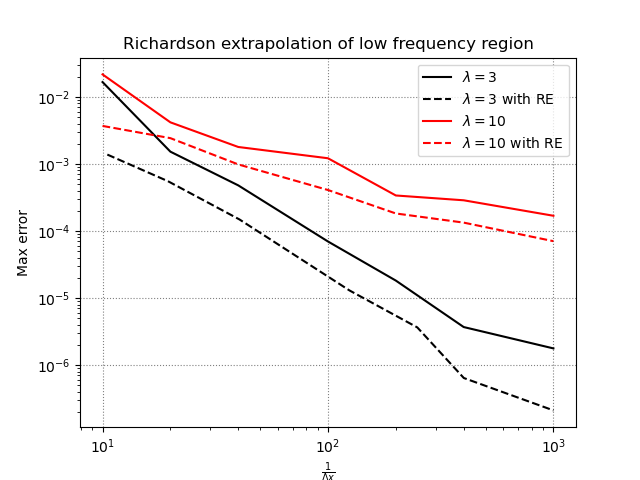

In [18]:
plt.figure()
plt.title('Richardson extrapolation of low frequency region')
plt.xlabel('$\\frac{1}{\\Delta x}$')
plt.ylabel('Max error')
plt.loglog(inv_dz_vals, CNl3_real_errors, label='$\\lambda = 3$', color='black')
plt.loglog(l3_inv_dz_vals, lCN_RE_l3, label='$\\lambda = 3$ with RE', linestyle='dashed', color='black')

plt.loglog(inv_dz_vals, CNl10_real_errors, label='$\\lambda = 10$', color='red')
plt.loglog(l10_inv_dz_vals, lCN_RE_l10, label='$\\lambda = 10$ with RE', linestyle='dashed', color='red')

plt.grid(True, linestyle='dotted', color='grey')
plt.legend()
plt.show()

## Cancelling FIRST Order Leading Error (HIGH FREQUENCY)

### Function

In [19]:
def CNRE_1OE(dt, lda, sig=sig, K=K, r=r, T=T):
    # Parameters
    Smin = 1e-10
    Smax = 500
    Zmin = np.log(Smin)
    Zmax = np.log(Smax)
    
    nt = int(T/dt)
    dZ = dt/lda
    iZ = m.floor((Zmax-Zmin) / dZ)
    Zmax = Zmin + dZ*iZ
    
    print(f'2h = {dZ}')
    print(f'2k = {dt}')
    print(f'lamda = {dt/dZ}')
    print(f'nt = {nt}')
    print(f'iZ = {iZ}')
    print(f'new Smax = {np.exp(Zmax)}')
    
    
    Z_2h = np.linspace(Zmin, Zmax, iZ+1)
    
    # Calculate CN Result for step size 2*dZ 
    V_2h = PresentValue(dZ = dZ, dt = dt, Zmax=Zmax)
    
    # Calculate CN Result for step size dZ
    V_h = PresentValue(dZ = dZ/2, dt = dt/2, Zmax=Zmax)
    
    
    # Conduct Richardson Extrapolation of Results: Solutions are only obtainable at the 2h steps (as no values calculated between 2h steps, as for h step case)
    V = np.zeros(iZ+1)
    for i in range(iZ+1):
        V[i] = 2 * V_h[2*i] - V_2h[i] 

    
    ### ---------------------------------------------
    # Calculate Max Error in Realistic Region

    # Errors
    # max
    Errors = DErrors_Z(V, Z_2h)
    # abs max
    Aerror = np.abs(Errors)
    
    
    # Define a cutoff at a large enough S and corresponding Z - THE REALISTIC DOMAIN
    Scut = 100
    Zcut = np.log(Scut)
    cutoff = int((Zcut - Zmin) / dZ)

    R_AE = Aerror[:cutoff]

    R_ME = np.max(R_AE)
    print('\n REALISTIC S DOMAIN ERRORS')
    print(f'1. Maximal error: {R_ME} \n')

    R_ME_ind = np.where(R_AE == R_ME)[0][0]
    print(f'located at {R_ME_ind}, z value of {Zmin + R_ME_ind*dZ}, S value of {np.exp(Zmin + R_ME_ind*dZ)} \n')


    return R_ME, V # realistic max error and solution via extrapolation

### Implementation: $\lambda = 3$ and $10$

In [20]:
l3_dt_vals = np.array([0.2857142857142857, 0.15384615384615385, 0.07407407407407407, 0.024096385542168676, 0.012048192771084338, 0.006006006006006006, 0.0029985007496251873])

#### $\lambda=3$

In [21]:
lda = 3

hCN_RE_l3 = []
l3_dz_vals = l3_dt_vals/lda
l3_inv_dz_vals = np.divide(np.ones(len(l3_dt_vals)), l3_dz_vals)

In [ ]:
dt = l3_dt_vals[0]
hCNRE_l3_1 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l3.append(hCNRE_l3_1)


dt = l3_dt_vals[1]
hCNRE_l3_2 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l3.append(hCNRE_l3_2)


dt = l3_dt_vals[2]
hCNRE_l3_3 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l3.append(hCNRE_l3_3)



dt = l3_dt_vals[3]
hCNRE_l3_4 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l3.append(hCNRE_l3_4)



dt = l3_dt_vals[4]
hCNRE_l3_5 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l3.append(hCNRE_l3_5)



dt = l3_dt_vals[5]
hCNRE_l3_6 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l3.append(hCNRE_l3_6)


dt = l3_dt_vals[6]
hCNRE_l3_7 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l3.append(hCNRE_l3_7)


2h = 0.09523809523809523
2k = 0.2857142857142857
lamda = 3.0
nt = 7
iZ = 307
new Smax = 498.8195006424106
Present Value Function:
dz = 0.09523809523809523
dt = 0.2857142857142857
lamda = 3.0
new Smax = 498.8195006424106
nt = 7
Present Value Function:
dz = 0.047619047619047616
dt = 0.14285714285714285
lamda = 3.0
new Smax = 498.8195006424106
nt = 14

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.010029801346373324 

located at 266, z value of 2.307482403392875, S value of 10.04909321823287 

2h = 0.05128205128205129
2k = 0.15384615384615385
lamda = 3.0
nt = 13
iZ = 570
new Smax = 495.178498614599
Present Value Function:
dz = 0.05128205128205129
dt = 0.15384615384615385
lamda = 3.0
new Smax = 495.178498614599
nt = 13
Present Value Function:
dz = 0.025641025641025644
dt = 0.07692307692307693
lamda = 3.0
new Smax = 495.178498614599
nt = 26

 REALISTIC S DOMAIN ERRORS
1. Maximal error: 0.0026119624049050216 

located at 494, z value of 2.3074824033928785, S value of 10.049093218232906 

2h

In [ ]:
hCN_RE_l3

#### $\lambda=10$

In [ ]:
hCN_RE_l10 = []

In [ ]:
lda = 10

dt = l10_dt_vals[0]
hCNRE_l10_1 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l10.append(hCNRE_l10_1)


dt = l10_dt_vals[1]
hCNRE_l10_2 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l10.append(hCNRE_l10_2)


dt = l10_dt_vals[2]
hCNRE_l10_3 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l10.append(hCNRE_l10_3)



dt = l10_dt_vals[3]
hCNRE_l10_4 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l10.append(hCNRE_l10_4)



dt = l10_dt_vals[4]
hCNRE_l10_5 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l10.append(hCNRE_l10_5)


dt = l10_dt_vals[5]
hCNRE_l10_6 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l10.append(hCNRE_l10_6)

dt = l10_dt_vals[6]
hCNRE_l10_7 = CNRE_1OE(dt=dt, lda=lda)[0]
hCN_RE_l10.append(hCNRE_l10_7)

In [ ]:
hCN_RE_l10

### Plot comparing to original

#### Plot

In [ ]:
dZ = 0.002
lda = 3

dt = lda * dZ
nt = round(T/dt)
dt = T/nt
print(dt)

In [ ]:
plt.figure()
plt.title('Richardson extrapolation of high frequency region')
plt.xlabel('$\\frac{1}{\\Delta x}$')
plt.ylabel('Max error')
plt.loglog(inv_dz_vals, CNl3_real_errors, label='$\\lambda = 3$', color='black')
plt.loglog(l3_inv_dz_vals, hCN_RE_l3, label='$\\lambda = 3$ with RE', linestyle='dashed', color='black')

plt.loglog(inv_dz_vals, CNl10_real_errors, label='$\\lambda = 10$', color='red')
plt.loglog(l10_inv_dz_vals, hCN_RE_l10, label='$\\lambda = 10$ with RE', linestyle='dashed', color='red')

plt.grid(True, linestyle='dotted', color='grey')
plt.legend()
plt.show()


# 2. Rannacher Timestepping Richardson Extrapolation

## Cancelling SECOND Order Leading Error (LOW FREQUENCY)

### Function

In [ ]:
def RRE_2OE(dZ, lda, R, sig=sig, K=K, r=r, T=T):
    # Parameters
    Smin = 1e-10
    Smax = 500
    Zmin = np.log(Smin)
    Zmax = np.log(Smax)
   
    dt = lda*dZ
    
    # get appropriate parameters
    iZ = round((Zmax-Zmin)/dZ)
    dZ = (Zmax-Zmin) / iZ
    nt = round(T/dt)
    dt = T/nt
    
    print(f'2h = {dZ}')
    print(f'2k = {dt}')
    print(f'lamda = {dt/dZ}')
    
    Z_2h = np.linspace(Zmin, Zmax, iZ+1)
    
    # Calculate CN Result for step size 2*dZ 
    V_2h = PV_Rannacher(dZ = dZ, dt = dt, R=R)
    
    # Calculate CN Result for step size dZ
    V_h = PV_Rannacher(dZ = dZ/2, dt = dt/2, R=R)
    
    
    # Conduct Richardson Extrapolation of Results: Solutions are only obtainable at the 2h steps (as no values calculated between 2h steps, as for h step case)
    V = np.zeros(iZ+1)
    for i in range(iZ+1):
        V[i] = 4/3 * V_h[2*i] - 1/3 * V_2h[i] 

    
    ### ---------------------------------------------
    # Calculate Max Error in Realistic Region

    # Errors
    # max
    Errors = DErrors_Z(V, Z_2h)
    # abs max
    Aerror = np.abs(Errors)
    
    
    # Define a cutoff at a large enough S and corresponding Z - THE REALISTIC DOMAIN
    Scut = 100
    Zcut = np.log(Scut)
    cutoff = int((Zcut - Zmin) / dZ)

    R_AE = Aerror[:cutoff]

    R_ME = np.max(R_AE)
    print('\n REALISTIC S DOMAIN ERRORS')
    print(f'1. Maximal error: {R_ME} \n')

    R_ME_ind = np.where(R_AE == R_ME)[0][0]
    print(f'located at {R_ME_ind}, z value of {Zmin + R_ME_ind*dZ}, S value of {np.exp(Zmin + R_ME_ind*dZ)} \n')


    return R_ME, V # realistic max error and solution via extrapolation

### Implementation: $\lambda = 3$ and $10$

In [ ]:
dz_vals = [0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001]
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)

#### $\lambda=3$

In [ ]:
lRCN_RE_l3 = []

In [ ]:
lda = 3

dZ = 0.1
lRCNRE_l3_1 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l3.append(lRCNRE_l3_1)


dZ = 0.05
lRCNRE_l3_2 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l3.append(lRCNRE_l3_2)


dZ = 0.025
lRCNRE_l3_3 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l3.append(lRCNRE_l3_3)



dZ = 0.01
lRCNRE_l3_4 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l3.append(lRCNRE_l3_4)



dZ = 0.005
lRCNRE_l3_5 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l3.append(lRCNRE_l3_5)



dZ = 0.0025
lRCNRE_l3_6 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l3.append(lRCNRE_l3_6)


dZ = 0.001
lRCNRE_l3_7 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l3.append(lRCNRE_l3_7)


In [ ]:
lRCN_RE_l3

#### $\lambda=10$

In [ ]:
lRCN_RE_l10 = []

In [ ]:
lda = 10

dZ = 0.1
lRCNRE_l10_1 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l10.append(lRCNRE_l10_1)


dZ = 0.05
lRCNRE_l10_2 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l10.append(lRCNRE_l10_2)


dZ = 0.025
lRCNRE_l10_3 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l10.append(lRCNRE_l10_3)



dZ = 0.01
lRCNRE_l10_4 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l10.append(lRCNRE_l10_4)



dZ = 0.005
lRCNRE_l10_5 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l10.append(lRCNRE_l10_5)



dZ = 0.0025
lRCNRE_l10_6 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l10.append(lRCNRE_l10_6)


dZ = 0.001
lRCNRE_l10_7 = RRE_2OE(dZ=dZ, lda=lda, R=1)[0]
lRCN_RE_l10.append(lRCNRE_l10_7)

In [ ]:
lRCN_RE_l10

### Plot comparing to original

#### Get corresponding original CN errors

In [ ]:
T=2
dz = 0.0025
dt = dz * 3
nt = round(T/dt)
print(T/nt)

In [ ]:
RCNl3 = pd.read_csv('RCN1 l3 data.csv')
RCNl3_real_errors = RCNl3['Real Errors']

RCNl10 = pd.read_csv('RCN1 l10 data.csv')
RCNl10_real_errors = RCNl10['Real Errors']

#### Plot

In [ ]:
plt.figure()
plt.title('Richardson extrapolation of low frequency region')
plt.xlabel('$\\frac{1}{\\Delta x}$')
plt.ylabel('Max error')
plt.loglog(inv_dz_vals, RCNl3_real_errors, label='$\\lambda = 3$', color='black')
plt.loglog(inv_dz_vals, lRCN_RE_l3, label='$\\lambda = 3$ with RE', linestyle='dashed', color='black')

plt.loglog(inv_dz_vals, RCNl10_real_errors, label='$\\lambda = 10$', color='red')
plt.loglog(inv_dz_vals, lRCN_RE_l10, label='$\\lambda = 10$ with RE', linestyle='dashed', color='red')

plt.grid(True, linestyle='dotted', color='grey')
plt.legend()
plt.show()

In [ ]:
lRCN_RE_l10

In [ ]:
lRCN_RE_l3

## Cancelling 2R+1 Order Leading Error (HIGH FREQUENCY)

### Function

In [ ]:
def RRE_1OE(dZ, lda, R, sig=sig, K=K, r=r, T=T):
    # Parameters
    Smin = 1e-10
    Smax = 500
    Zmin = np.log(Smin)
    Zmax = np.log(Smax)
   
    dt = lda*dZ
    
    # get appropriate parameters
    iZ = round((Zmax-Zmin)/dZ)
    dZ = (Zmax-Zmin) / iZ
    nt = round(T/dt)
    dt = T/nt
    
    print(f'2h = {dZ}')
    print(f'2k = {dt}')
    print(f'lamda = {dt/dZ}')
    
    Z_2h = np.linspace(Zmin, Zmax, iZ+1)
    
    # Calculate CN Result for step size 2*dZ 
    V_2h = PV_Rannacher(dZ = dZ, dt = dt, R=R)
    
    # Calculate CN Result for step size dZ
    V_h = PV_Rannacher(dZ = dZ/2, dt = dt/2, R=R)
    
    
    # Conduct Richardson Extrapolation of Results: Solutions are only obtainable at the 2h steps (as no values calculated between 2h steps, as for h step case)
    V = np.zeros(iZ+1)
    for i in range(iZ+1):
        V[i] = 8/7 * V_h[2*i] - 1/7 * V_2h[i] # R = 1 implies 2R+1 = 3rd order convergence

    
    ### ---------------------------------------------
    # Calculate Max Error in Realistic Region

    # Errors
    # max
    Errors = DErrors_Z(V, Z_2h)
    # abs max
    Aerror = np.abs(Errors)
    
    
    # Define a cutoff at a large enough S and corresponding Z - THE REALISTIC DOMAIN
    Scut = 100
    Zcut = np.log(Scut)
    cutoff = int((Zcut - Zmin) / dZ)

    R_AE = Aerror[:cutoff]

    R_ME = np.max(R_AE)
    print('\n REALISTIC S DOMAIN ERRORS')
    print(f'1. Maximal error: {R_ME} \n')

    R_ME_ind = np.where(R_AE == R_ME)[0][0]
    print(f'located at {R_ME_ind}, z value of {Zmin + R_ME_ind*dZ}, S value of {np.exp(Zmin + R_ME_ind*dZ)} \n')


    return R_ME, V # realistic max error and solution via extrapolation
    
    

### Implementation: $\lambda = 3, 6$ and $10$

In [ ]:
dz_vals = [0.1, 0.05, 0.025, 0.01, 0.005, 0.0025, 0.001]
inv_dz_vals = np.divide(np.ones(len(dz_vals)), dz_vals)

#### $\lambda=3$

In [ ]:
hRCN_RE_l3 = []

In [ ]:
lda = 4

dZ = 0.1
hRCNRE_l3_1 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l3.append(hRCNRE_l3_1)


dZ = 0.05
hRCNRE_l3_2 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l3.append(hRCNRE_l3_2)


dZ = 0.025
hRCNRE_l3_3 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l3.append(hRCNRE_l3_3)



dZ = 0.01
hRCNRE_l3_4 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l3.append(hRCNRE_l3_4)



dZ = 0.005
hRCNRE_l3_5 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l3.append(hRCNRE_l3_5)



dZ = 0.0025
hRCNRE_l3_6 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l3.append(hRCNRE_l3_6)


dZ = 0.001
hRCNRE_l3_7 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l3.append(hRCNRE_l3_7)


In [ ]:
hRCN_RE_l3

#### $\lambda=10$

In [ ]:
hRCN_RE_l10 = []

In [ ]:
lda = 10

dZ = 0.1
hRCNRE_l10_1 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l10.append(hRCNRE_l10_1)


dZ = 0.05
hRCNRE_l10_2 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l10.append(hRCNRE_l10_2)


dZ = 0.025
hRCNRE_l10_3 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l10.append(hRCNRE_l10_3)



dZ = 0.01
hRCNRE_l10_4 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l10.append(hRCNRE_l10_4)



dZ = 0.005
hRCNRE_l10_5 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l10.append(hRCNRE_l10_5)



dZ = 0.0025
hRCNRE_l10_6 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l10.append(hRCNRE_l10_6)


dZ = 0.001
hRCNRE_l10_7 = RRE_1OE(dZ=dZ, lda=lda, R=1)[0]
hRCN_RE_l10.append(hRCNRE_l10_7)

In [ ]:
hRCN_RE_l10

### Plot comparing to original

#### Get corresponding original CN errors

In [ ]:
RCNl3 = pd.read_csv('RCN1 l3 data.csv')
RCNl3_real_errors = RCNl3['Real Errors']

RCNl10 = pd.read_csv('RCN1 l10 data.csv')
RCNl10_real_errors = RCNl10['Real Errors']

#### Plot

In [ ]:
plt.figure()
plt.title('Richardson extrapolation of high frequency region')
plt.xlabel('$\\frac{1}{\\Delta x}$')
plt.ylabel('Max error')
plt.loglog(inv_dz_vals, RCNl3_real_errors, label='$\\lambda = 3$', color='black')
plt.loglog(inv_dz_vals, hRCN_RE_l3, label='$\\lambda = 3$ with RE', linestyle='dashed', color='black')

plt.loglog(inv_dz_vals, RCNl10_real_errors, label='$\\lambda = 10$', color='red')
plt.loglog(inv_dz_vals, hRCN_RE_l10, label='$\\lambda = 10$ with RE', linestyle='dashed', color='red')

plt.grid(True, linestyle='dotted', color='grey')
plt.legend()
plt.show()
